In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchsummary
from seaborn.external.docscrape import header

import utils.audio_utils
from utils.preprocess import LyricPreprocessor
from sklearn.preprocessing import LabelEncoder
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification
from torch.utils.data import DataLoader
import torchvision.models as models
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import joblib
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import seaborn as sns

/Users/julia.rozycka/Master/Multimodal Genre Classifier/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the data from csv for lyrics
df = pd.read_csv('data/fma_cut100_echonest_lyrics_fake_country.csv', header=[0, 1])
df.sort_values(('track', 'one_genre'), inplace=True)

In [3]:
# Load the data from csv for lyrics
foo = pd.read_csv('data/fma_cut100_echonest_lyrics_fake_country.csv', header=[0, 1])
foo.sort_values(('track', 'one_genre'), inplace=True)
foo[foo[('track', 'language_code')].isin(['it', 'es'])]

track    album                                                        \
    track_id comments         date_created date_released engineer favorites   
8      20467        0  2009-11-04 02:49:44           NaN      NaN         0   
7      20468        0  2009-11-04 02:49:44           NaN      NaN         0   
6      20469        0  2009-11-04 02:49:44           NaN      NaN         0   
5      20470        0  2009-11-04 02:49:44           NaN      NaN         0   
4      20471        0  2009-11-04 02:49:44           NaN      NaN         0   
3      20472        0  2009-11-04 02:49:44           NaN      NaN         0   
10     20466        0  2009-11-04 02:49:44           NaN      NaN         0   
2      20473        0  2009-11-04 02:49:44           NaN      NaN         0   
494    31878        0  2010-06-21 16:01:19           NaN      NaN         6   

                                                                               \
       id                                        information listens producer   
8    4612  <p>ZONA MC, from Italy is the lone Artist to c...    2662      NaN   
7    4612  <p>ZONA MC, from Italy is the lone Artist to c...    2662      NaN   
6    4612  <p>ZONA MC, from Italy is the lone Artist to c...    2662      NaN   
5    4612  <p>ZONA MC, from Italy is the lone Artist to c...    2662      NaN   
4    4612  <p>ZONA MC, from Italy is the lone Artist to c...    2662      NaN   
3    4612  <p>ZONA MC, from Italy is the lone Artist to c...    2662      NaN   
10   4612  <p>ZONA MC, from Italy is the lone Artist to c...    2662      NaN   
2    4612  <p>ZONA MC, from Italy is the lone Artist to c...    2662      NaN   
494  6645  <p><em>This is a free "pirate disc" sampler fr...   96836      NaN   

     ...     track                                                  \
     ... one_genre danceability    energy speechiness acousticness   
8    ...   Hip-Hop     0.311028  0.939475    0.368050     0.739839   
7    ...   Hip-Hop     0.494588  0.685102    0.097566     0.142804   
6    ...   Hip-Hop     0.717483  0.759159    0.417283     0.958509   
5    ...   Hip-Hop     0.753637  0.780335    0.280395     0.858177   
4    ...   Hip-Hop     0.523664  0.631565    0.427540     0.675857   
3    ...   Hip-Hop     0.692302  0.770812    0.076767     0.552559   
10   ...   Hip-Hop     0.398472  0.796359    0.067976     0.950119   
2    ...   Hip-Hop     0.415292  0.697336    0.433429     0.911632   
494  ...       Pop     0.628309  0.932136    0.083717     0.836270   

                                                                
    instrumentalness  liveness   valence    tempo track_folder  
8           0.000000  0.290111  0.590517  176.831           20  
7           0.181599  0.127996  0.699157  116.755           20  
6           0.328549  0.111719  0.934794  173.882           20  
5           0.095992  0.129764  0.815886   89.069           20  
4           0.007069  0.111112  0.148784   87.667           20  
3           0.734064  0.110137  0.429266   91.759           20  
10          0.025630  0.213626  0.711232  146.068           20  
2           0.017604  0.099029  0.764465  169.933           20  
494         0.084272  0.069030  0.830856  196.006           31  

[9 rows x 67 columns]

In [4]:
df = df[df['track', 'language_code'].isin(['en', np.nan])]

In [5]:
df.sample()

track    album                                                         \
    track_id comments         date_created        date_released     engineer   
343     8450        4  2009-03-25 13:41:40  2009-03-22 00:00:00  Jason Sigal   

                                                                        \
    favorites    id                                        information   
343         1  2188  <p><span style="font-family: Verdana,Geneva,Ar...   

                             ...     track                                     \
    listens        producer  ... one_genre danceability    energy speechiness   
343    3040  Keili Hamilton  ...      Rock      0.25261  0.786539     0.03698   

                                                                            
    acousticness instrumentalness  liveness  valence    tempo track_folder  
343     0.064656          0.86596  0.078937  0.69478  180.261            8  

[1 rows x 67 columns]

## Lyrics

In [6]:
# Preprocess the lyrics
lyrics = ('track', 'lyrics')

lyricPreprocessor = LyricPreprocessor(lyrics=lyrics)
df_lyrics = lyricPreprocessor.preprocess_lyrics(df, ('track', 'lemmatized_lyrics'))

Handling contractions: 100%|██████████| 568/568 [00:00<00:00, 33025.56it/s]
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/julia.rozycka/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/julia.rozycka/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/julia.rozycka/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/julia.rozycka/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
100%|██████████| 568/568 [00:02<00:00, 281.84it/s]


In [7]:
df_lyrics

track    album                                            \
    track_id comments         date_created        date_released   
576    91935        0  2013-10-10 16:33:42  2013-09-28 00:00:00   
543    12917        0  2009-05-14 07:10:28                  NaN   
542    12915        0  2009-05-14 07:10:28                  NaN   
541    12902        0  2009-05-14 07:10:28                  NaN   
540    12885        0  2009-05-14 07:10:28                  NaN   
..       ...      ...                  ...                  ...   
366    11664        0  2009-04-28 23:58:48                  NaN   
365    33542        1  2010-08-03 19:45:03                  NaN   
364    66655        0  2012-06-19 12:13:52  2012-06-16 00:00:00   
344    47951        5  2011-05-20 16:31:08  2011-04-27 00:00:00   
318     4254        0  2008-12-04 09:29:25  2001-07-19 00:00:00   

                                                      \
                           engineer favorites     id   
576                             NaN         0  15205   
543                             NaN         7   3077   
542                             NaN         7   3077   
541                             NaN         7   3077   
540                             NaN         7   3077   
..                              ...       ...    ...   
366                             NaN         0   2867   
365                             NaN         6   7011   
364  Jason Sigal w/ Justin Colletti         1  11962   
344                  Ernie Indradat         0   9211   
318                    Diane Farris         0   1600   

                                                                \
                                           information listens   
576  <div><span><span style="font-family: arial, he...    4828   
543  <p>From Roger McGuinn's <a href="http://www.ib...  139700   
542  <p>From Roger McGuinn's <a href="http://www.ib...  139700   
541  <p>From Roger McGuinn's <a href="http://www.ib...  139700   
540  <p>From Roger McGuinn's <a href="http://www.ib...  139700   
..                                                 ...     ...   
366                                                NaN     739   
365  <p>Recorded live in Nuremberg, 2009.</p>\n<p> ...   14913   
364  <p>Vermont's King Tuff are led by Kyle Thomas,...    3102   
344  <p>DJ Keili of Beastin' The Airwaves! welcomes...    2587   
318  <p>http://www.wfmu.org/Playlists/Joeb/joeb.010...    8830   

                     ...        track                                     \
           producer  ... danceability    energy speechiness acousticness   
576             NaN  ...     0.663895  0.362650    0.026750     0.841821   
543             NaN  ...     0.430531  0.352678    0.027157     0.951153   
542             NaN  ...     0.422721  0.392883    0.055997     0.986825   
541             NaN  ...     0.429686  0.434506    0.026000     0.658341   
540             NaN  ...     0.607850  0.338398    0.037315     0.972244   
..              ...  ...          ...       ...         ...          ...   
366             NaN  ...     0.465603  0.507497    0.026249     0.768220   
365             NaN  ...     0.355776  0.442472    0.031735     0.927991   
364         Terre T  ...     0.172863  0.904603    0.061700     0.000008   
344  Keili Hamilton  ...     0.418464  0.522099    0.030471     0.898431   
318             NaN  ...     0.217909  0.248152    0.031438     0.775916   

                                                                \
    instrumentalness  liveness   valence    tempo track_folder   
576     1.511013e-02  0.237332  0.379564   97.634           91   
543     7.901457e-01  0.123691  0.667873  101.179           12   
542     2.180000e-08  0.117046  0.883695  186.809           12   
541     6.087492e-02  0.102025  0.659604   89.175           12   
540     3.926800e-06  0.089071  0.962536  119.882           12   
..               ...       ...       ...      ...          ...   
366     9.174003e-01  0.166159

In [8]:
df_lyrics

track    album                                            \
    track_id comments         date_created        date_released   
576    91935        0  2013-10-10 16:33:42  2013-09-28 00:00:00   
543    12917        0  2009-05-14 07:10:28                  NaN   
542    12915        0  2009-05-14 07:10:28                  NaN   
541    12902        0  2009-05-14 07:10:28                  NaN   
540    12885        0  2009-05-14 07:10:28                  NaN   
..       ...      ...                  ...                  ...   
366    11664        0  2009-04-28 23:58:48                  NaN   
365    33542        1  2010-08-03 19:45:03                  NaN   
364    66655        0  2012-06-19 12:13:52  2012-06-16 00:00:00   
344    47951        5  2011-05-20 16:31:08  2011-04-27 00:00:00   
318     4254        0  2008-12-04 09:29:25  2001-07-19 00:00:00   

                                                      \
                           engineer favorites     id   
576                             NaN         0  15205   
543                             NaN         7   3077   
542                             NaN         7   3077   
541                             NaN         7   3077   
540                             NaN         7   3077   
..                              ...       ...    ...   
366                             NaN         0   2867   
365                             NaN         6   7011   
364  Jason Sigal w/ Justin Colletti         1  11962   
344                  Ernie Indradat         0   9211   
318                    Diane Farris         0   1600   

                                                                \
                                           information listens   
576  <div><span><span style="font-family: arial, he...    4828   
543  <p>From Roger McGuinn's <a href="http://www.ib...  139700   
542  <p>From Roger McGuinn's <a href="http://www.ib...  139700   
541  <p>From Roger McGuinn's <a href="http://www.ib...  139700   
540  <p>From Roger McGuinn's <a href="http://www.ib...  139700   
..                                                 ...     ...   
366                                                NaN     739   
365  <p>Recorded live in Nuremberg, 2009.</p>\n<p> ...   14913   
364  <p>Vermont's King Tuff are led by Kyle Thomas,...    3102   
344  <p>DJ Keili of Beastin' The Airwaves! welcomes...    2587   
318  <p>http://www.wfmu.org/Playlists/Joeb/joeb.010...    8830   

                     ...        track                                     \
           producer  ... danceability    energy speechiness acousticness   
576             NaN  ...     0.663895  0.362650    0.026750     0.841821   
543             NaN  ...     0.430531  0.352678    0.027157     0.951153   
542             NaN  ...     0.422721  0.392883    0.055997     0.986825   
541             NaN  ...     0.429686  0.434506    0.026000     0.658341   
540             NaN  ...     0.607850  0.338398    0.037315     0.972244   
..              ...  ...          ...       ...         ...          ...   
366             NaN  ...     0.465603  0.507497    0.026249     0.768220   
365             NaN  ...     0.355776  0.442472    0.031735     0.927991   
364         Terre T  ...     0.172863  0.904603    0.061700     0.000008   
344  Keili Hamilton  ...     0.418464  0.522099    0.030471     0.898431   
318             NaN  ...     0.217909  0.248152    0.031438     0.775916   

                                                                \
    instrumentalness  liveness   valence    tempo track_folder   
576     1.511013e-02  0.237332  0.379564   97.634           91   
543     7.901457e-01  0.123691  0.667873  101.179           12   
542     2.180000e-08  0.117046  0.883695  186.809           12   
541     6.087492e-02  0.102025  0.659604   89.175           12   
540     3.926800e-06  0.089071  0.962536  119.882           12   
..               ...       ...       ...      ...          ...   
366     9.174003e-01  0.166159

In [9]:
# Check when lyrics language is 'it' or 'es'
df_lyrics[df_lyrics[('track', 'language_code')].isin(['it', 'es'])]


Empty DataFrame
Columns: [(track, track_id), (album, comments), (album, date_created), (album, date_released), (album, engineer), (album, favorites), (album, id), (album, information), (album, listens), (album, producer), (album, tags), (album, title), (album, tracks), (album, type), (artist, active_year_begin), (artist, active_year_end), (artist, associated_labels), (artist, bio), (artist, comments), (artist, date_created), (artist, favorites), (artist, id), (artist, latitude), (artist, location), (artist, longitude), (artist, members), (artist, name), (artist, related_projects), (artist, tags), (artist, website), (artist, wikipedia_page), (set, split), (set, subset), (track, bit_rate), (track, comments), (track, composer), (track, date_created), (track, date_recorded), (track, duration), (track, favorites), (track, genre_top), (track, genres), (track, genres_all), (track, information), (track, interest), (track, language_code), (track, license), (track, listens), (track, lyricist), (track, number), (track, publisher), (track, tags), (track, title), (artist, name_clean), (track, title_clean), (track, key), (track, lyrics), (track, one_genre), (track, danceability), (track, energy), (track, speechiness), (track, acousticness), (track, instrumentalness), (track, liveness), (track, valence), (track, tempo), (track, track_folder), (track, lemmatized_lyrics)]
Index: []

[0 rows x 68 columns]

In [10]:
y_lyrics = df_lyrics[('track','one_genre')]

label_encoder = LabelEncoder()
y_lyrics = label_encoder.fit_transform(y_lyrics)
y_lyrics = np.eye(len(label_encoder.classes_))[y_lyrics]  # One-hot encode genres

X_lyrics = df_lyrics[('track', 'lemmatized_lyrics')]

In [11]:
# Load model
device = 'mps'

# Initialize tokenizer and model
tokenizer = RobertaTokenizerFast.from_pretrained("distilroberta-base")
model_lyrics = RobertaForSequenceClassification.from_pretrained(
    "distilroberta-base",
    num_labels=8,
).to(device)

model_lyrics.load_state_dict(torch.load("models/lyrics_genre_model_alphabetically.pt", map_location=device, weights_only=True))
model_lyrics.to(device)
model_lyrics.eval()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
           

In [12]:
from utils.lyrics_utils import LyricsGenreDataset

batch_size = 24
dataset = LyricsGenreDataset(X_lyrics, y_lyrics, tokenizer)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

## Audio

In [13]:
# Load the data from csv for audio

from utils.audio_utils import MelSpectogramDataset

mel_dataset = MelSpectogramDataset(data_path='mel_spectrogram')
dataset_loader = DataLoader(mel_dataset, batch_size=64)

In [14]:
# Evaluate the model on the test set
audio_model = models.resnet18()
audio_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=True)
audio_model.maxpool = nn.MaxPool2d(3, stride=2, padding=1)
audio_model.fc = nn.Linear(512, 8)

audio_model = audio_model.to("mps")

audio_model.load_state_dict(torch.load("models/resnet_model_v1_weighted_alphabetical_normalize_fma.pt", weights_only=True))

audio_model.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2):

In [15]:
# Get number of samples in test_loader

num_samples = 0
for mel_spectrogram, label in dataset_loader:
    num_samples += mel_spectrogram.size(0)
print(num_samples)

568


## Metadata

In [16]:
# Load the data from csv for metadata
df[('album','year_released')] = df[('album', 'date_released')].str.extract(r'(\d{4})')

In [17]:
df[('album', 'year_released')] = df[('album', 'year_released')].astype(float)

In [18]:
df[[('album', 'year_released'), ('track', 'one_genre')]]

,album,track
,year_released,one_genre
576,2013.0,Country
543,NaN,Country
542,NaN,Country
541,NaN,Country
540,NaN,Country
...,...,...
366,NaN,Rock
365,NaN,Rock
364,2012.0,Rock


In [19]:
features = [('track', 'danceability'), ('track', 'energy'), ('track', 'speechiness'), ('track', 'acousticness'), ('track', 'instrumentalness'), ('track', 'liveness'), ('track', 'valence'), ('track', 'tempo'), ('track', 'duration'), ('album', 'year_released')]

In [20]:
df_metadata = df[features + [('track', 'one_genre')]]

In [21]:
# Drop first level of header
df_metadata.columns = df_metadata.columns.droplevel(0)

In [22]:
df_metadata

,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration,year_released,one_genre
576,0.663895,0.362650,0.026750,0.841821,1.511013e-02,0.237332,0.379564,97.634,272,2013.0,Country
543,0.430531,0.352678,0.027157,0.951153,7.901457e-01,0.123691,0.667873,101.179,210,NaN,Country
542,0.422721,0.392883,0.055997,0.986825,2.180000e-08,0.117046,0.883695,186.809,116,NaN,Country
541,0.429686,0.434506,0.026000,0.658341,6.087492e-02,0.102025,0.659604,89.175,222,NaN,Country
540,0.607850,0.338398,0.037315,0.972244,3.926800e-06,0.089071,0.962536,119.882,157,NaN,Country
...,...,...,...,...,...,...,...,...,...,...,...
366,0.465603,0.507497,0.026249,0.768220,9.174003e-01,0.166159,0.690850,96.756,154,NaN,Rock
365,0.355776,0.442472,0.031735,0.927991,8.548153e-01,0.737811,0.565145,112.310,283,NaN,Rock
364,0.172863,0.904603,0.061700,0.000008,6.973964e-01,0.404538,0.222476,115.109,193,2012.0,Rock
344,0.418464,0.522099,0.030471,0.898431,9.070645e-01,0.116164,0.516430,93.211,179,2011.0,Rock


In [23]:
# Fill na of year released with median values grouped by genre
df_metadata['year_released'] = df_metadata.groupby('one_genre')['year_released'].transform(lambda x: x.fillna(x.median()))

/var/folders/b9/g8km3d4d6bl780pwnb5dnhxjd5x2_h/T/ipykernel_5797/401054518.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_metadata['year_released'] = df_metadata.groupby('one_genre')['year_released'].transform(lambda x: x.fillna(x.median()))


In [24]:
features = ['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration', 'year_released']

In [25]:
# Select the features from the new dataset
X_metadata = df_metadata[features]
y_metadata = df_metadata['one_genre']
label_encoder = LabelEncoder()
y_metadata = label_encoder.fit_transform(y_metadata)

# Normalize the features
scaler = StandardScaler()
X_metadata = scaler.fit_transform(X_metadata)


In [26]:
# Load model
metadata_model = joblib.load('models/xgb_metadata_v1_8_genres_smote_normalized.joblib')

In [27]:
y_metadata

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

In [28]:
X_metadata

array([[ 1.14664836, -0.73123147, -0.53141289, ..., -0.73179838,
         0.13280226,  1.03545236],
       [-0.16305934, -0.76738732, -0.5277386 , ..., -0.63240317,
        -0.24655889,  0.01126962],
       [-0.2068942 , -0.62161418, -0.26783839, ...,  1.76850298,
        -0.82171934,  0.01126962],
       ...,
       [-1.60916835,  1.23373352, -0.21644001, ..., -0.24183184,
        -0.35057727,  0.77940667],
       [-0.23078417, -0.15311581, -0.49787306, ..., -0.85581109,
        -0.43623947,  0.52336099],
       [-1.35635668, -1.14636821, -0.48916394, ...,  0.73426001,
        -0.36281473, -2.03709586]])

In [29]:
# Save features and labels from metadata

## Weighted Voting

In [30]:
# Extract predictions from lyrics

def evaluate_model_single_genre(model, test_loader, device):
    model.eval()
    test_preds, test_labels, test_probs = [], [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)

            # Get probabilities
            probs = torch.sigmoid(outputs.logits).cpu().numpy()
            test_probs.extend(probs)

            test_preds.extend(np.argmax(probs, axis=1))
            test_labels.extend(np.argmax(labels.cpu().numpy(), axis=1))

    test_accuracy = accuracy_score(test_labels, test_preds)
    test_f1 = f1_score(test_labels, test_preds, average="macro")
    print(f"Test Accuracy: {test_accuracy}")
    print(f"Test F1 Score: {test_f1}")

    return test_labels, test_preds, test_probs

# Run evaluation and get predictions and labels
lyrics_labels, lyrics_preds, lyrics_probs = evaluate_model_single_genre(model_lyrics, data_loader, device)

Test Accuracy: 0.4014084507042254
Test F1 Score: 0.3193300083584534


In [31]:
# Get example predictions from lyrics model and assigned label for 1 sample
example_idx = 0
example_pred = lyrics_preds[example_idx]
example_label = lyrics_labels[example_idx]

print("Example prediction:", example_pred)
print("Example label:", example_label)
# Get the assigned genre for the example
assigned_genre = label_encoder.inverse_transform([example_label.argmax()])[0]
print("Assigned genre:", assigned_genre)

# Get true genre for the example
true_genre = label_encoder.inverse_transform([np.argmax(y_lyrics[example_idx])])[0]
print("True genre:", true_genre)

Example prediction: 2
Example label: 0
Assigned genre: Country
True genre: Country


In [32]:
# Get predictions from the audio model
# Get predictions from the audio model
from tqdm import tqdm

criterion = nn.CrossEntropyLoss()

with torch.no_grad():
    correct, total = 0, 0
    audio_preds, audio_labels = [], []
    test_progress = tqdm(dataset_loader, desc="Testing", leave=False)

    for mel_spectrogram, label in test_progress:
        mel_spectrogram, label = mel_spectrogram.to("mps").float(), label.to("mps")
        output = audio_model(mel_spectrogram.unsqueeze(1))
        probabilities = nn.Softmax(dim=1)(output).cpu().numpy()
        audio_preds.append(probabilities)
        audio_labels.append(label.cpu().numpy())
        _, predicted = torch.max(output.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()

        # Calculate the loss
        loss = criterion(output, label)
        test_progress.set_postfix({"Loss": f"{loss.item():.4f}"})

    # Concatenate all predictions and true labels
    audio_labels = np.concatenate(audio_labels)
    audio_preds = np.concatenate(audio_preds)

    # Calculate metrics
    metrics = utils.audio_utils.calculate_metrics(audio_labels, audio_preds, num_classes=8)
    print("OVERALL METRICS")

    print(f"Accuracy: {100 * correct / total:.2f}% | Metrics: {metrics}")

OVERALL METRICS
Accuracy: 46.48% | Metrics: {'AUC': 0.8433563180087085, 'Precision': 0.48584849713424455, 'Recall': 0.49487217027371544, 'F1 Score': 0.46084219722376885}


In [33]:
audio_preds[0]

array([0.10434593, 0.00150872, 0.21217139, 0.28069574, 0.12985209,
       0.18501277, 0.00683484, 0.07957848], dtype=float32)

In [34]:
audio_labels[0]

0

In [35]:
from utils.audio_utils import calculate_metrics

# Calculate metrics
calculate_metrics(audio_labels, audio_preds, 8)

{'AUC': 0.8433563180087085,
 'Precision': 0.48584849713424455,
 'Recall': 0.49487217027371544,
 'F1 Score': 0.46084219722376885}

In [36]:
# Get example predictions from audio model for 1 sample
example_idx = 0
example_pred = audio_preds[example_idx]

print("Example prediction:", example_pred)

# Position with the highest probability
print("Position with the highest probability:", np.argmax(example_pred, axis=0))
# Get the assigned genre for the example
assigned_genre = mel_dataset.genres[np.argmax(example_pred, axis=0)]
print("Assigned genre:", assigned_genre)

# Get true label for the example using dataset class
true_label = mel_dataset.genres[example_idx]
print("True label:", true_label, mel_dataset[example_idx][1])

Example prediction: [0.10434593 0.00150872 0.21217139 0.28069574 0.12985209 0.18501277
 0.00683484 0.07957848]
Position with the highest probability: 3
Assigned genre: Jazz
True label: Country 0


In [37]:
# Get predictions from the metadata model
metadata_preds = metadata_model.predict_proba(X_metadata)  # Get probabilities from XGBoost

In [38]:
# Get example predictions from metadata model for 1 sample
example_idx = 0
example_pred = metadata_preds[example_idx]
example_pred

# Position with the highest probability
print("Position with the highest probability:", np.argmax(example_pred, axis=0))

# Get the assigned genre for the example
assigned_genre = label_encoder.inverse_transform([np.argmax(example_pred)])[0]
print("Assigned genre:", assigned_genre)

# Get true label for the example
true_label = label_encoder.inverse_transform([y_metadata[example_idx]])[0]
print("True label:", true_label)

Position with the highest probability: 6
Assigned genre: Rap
True label: Country


In [39]:
# Convert to numpy array
lyrics_probs = np.array(lyrics_probs)

In [40]:
lyrics_probs

array([[1.4031859e-02, 1.5633887e-03, 9.2956609e-01, ..., 4.3581612e-03,
        5.5142672e-04, 1.1620977e-03],
       [1.2422914e-02, 6.9526252e-03, 6.6592389e-01, ..., 1.1456213e-02,
        8.5178867e-04, 3.7787866e-04],
       [2.9902659e-02, 1.0137752e-03, 8.9072824e-01, ..., 5.9647653e-03,
        3.3338714e-04, 1.8145890e-03],
       ...,
       [1.8929897e-03, 2.4041187e-03, 1.5968722e-01, ..., 2.1362405e-03,
        2.5744984e-04, 1.4075311e-04],
       [1.7180765e-02, 2.0450980e-03, 9.3806720e-01, ..., 4.4454644e-03,
        7.2959857e-04, 8.4262417e-04],
       [1.8307215e-02, 1.7965415e-03, 9.3650168e-01, ..., 4.2159883e-03,
        6.6611165e-04, 1.1542916e-03]], dtype=float32)

In [41]:
weights = {
    "lyrics": 0.40,
    "audio": 0.25,
    "metadata": 0.35
}

# Weighted sum of probabilities
combined_probs = (
    lyrics_probs * weights["lyrics"] +
    audio_preds * weights["audio"] +
    metadata_preds * weights["metadata"]
)

In [42]:
y_lyrics

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [43]:
# Final predictions
final_preds = np.argmax(combined_probs, axis=1)

Weighted Voting Accuracy: 0.4824
Classification Report:
              precision    recall  f1-score   support

     Country       0.12      0.02      0.03        60
     Hip-Hop       0.40      0.11      0.18        35
       Indie       0.35      0.67      0.46        95
        Jazz       0.64      0.98      0.77        82
       Metal       0.47      0.90      0.62        51
         Pop       0.58      0.11      0.19        99
         Rap       0.59      0.89      0.71        46
        Rock       0.49      0.27      0.35       100

    accuracy                           0.48       568
   macro avg       0.45      0.49      0.41       568
weighted avg       0.47      0.48      0.41       568

Weighted Voting F1 Score: 0.4092


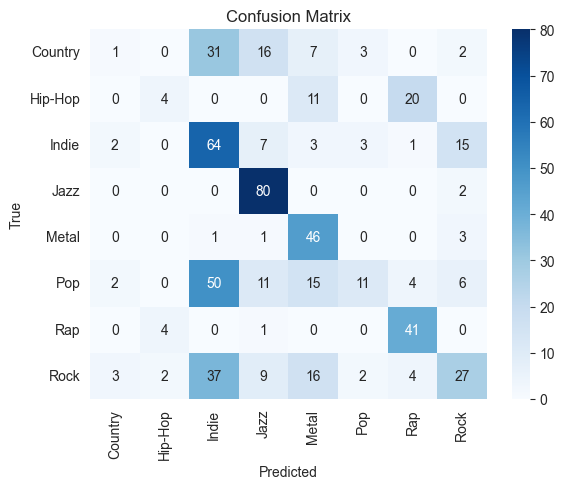

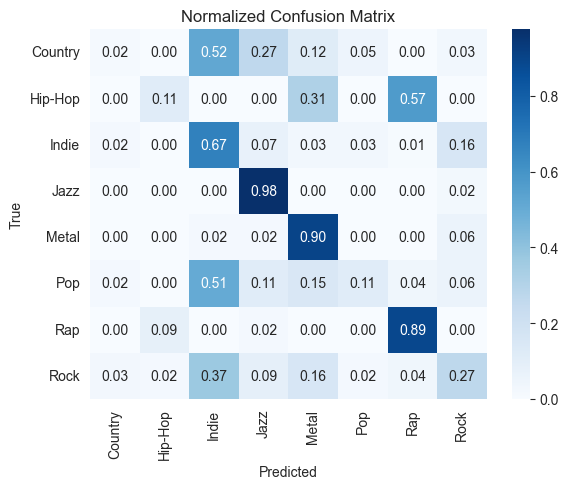

In [44]:
# True labels
true_labels = audio_labels
 # Assuming all labels are the same

# Accuracy
accuracy = accuracy_score(true_labels, final_preds)
print(f"Weighted Voting Accuracy: {accuracy:.4f}")

# Classification report
print("Classification Report:")
print(classification_report(true_labels, final_preds, target_names=label_encoder.classes_))

# F1 score
f1 = f1_score(true_labels, final_preds, average="weighted")
print(f"Weighted Voting F1 Score: {f1:.4f}")

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, final_preds)

# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Normalize the confusion matrix
conf_matrix = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [45]:

def late_fusion_objective(trial):
    """
    Objective function for finding the best weights for late fusion.

    Args:
        trial: Optuna trial object.

    Returns:
        float: F1 score of the weighted combination of predictions.
    """
    # Suggest weights for the modalities
    w_metadata = trial.suggest_float("w_metadata", 0.0, 0.6)
    w_temp = 1 - w_metadata
    w_lyrics = trial.suggest_float("w_lyrics", 0.0, w_temp)
    w_audio = 1.0 - w_metadata - w_lyrics  # Ensure the weights sum to 1

    # Skip invalid combinations where weights are negative
    if w_audio < 0:
        return 0.0

    # Weighted fusion of predictions
    final_predictions = (
        lyrics_probs * w_lyrics +
        audio_preds * w_audio +
        metadata_preds * w_metadata
    )

    # Convert probabilities to class predictions
    final_labels = np.argmax(final_predictions, axis=1)

    # Calculate F1 score
    return f1_score(true_labels, final_labels, average="macro")

In [47]:
import optuna

# Create an Optuna study
study = optuna.create_study(direction="maximize", study_name="late_fusion_study_v3", storage="sqlite:///late_fusion.db", load_if_exists=True)
study.optimize(late_fusion_objective, n_trials=100)

# Print the best weights and F1 score
print("Best weights:", study.best_params)
print("Best F1 score:", study.best_value)

[I 2025-01-29 14:14:12,919] Using an existing study with name 'late_fusion_study_v3' instead of creating a new one.
[I 2025-01-29 14:14:12,985] Trial 400 finished with value: 0.4861081498879671 and parameters: {'w_metadata': 0.10229400573693974, 'w_lyrics': 0.19398481520371808}. Best is trial 262 with value: 0.5037654313107423.
[I 2025-01-29 14:14:13,012] Trial 401 finished with value: 0.5011758218444861 and parameters: {'w_metadata': 0.07338331649590112, 'w_lyrics': 0.2121510472424436}. Best is trial 262 with value: 0.5037654313107423.
[I 2025-01-29 14:14:13,041] Trial 402 finished with value: 0.4987501870838846 and parameters: {'w_metadata': 0.08299552654172906, 'w_lyrics': 0.18279484214863911}. Best is trial 262 with value: 0.5037654313107423.
[I 2025-01-29 14:14:13,069] Trial 403 finished with value: 0.4913795882286391 and parameters: {'w_metadata': 0.05813894716856738, 'w_lyrics': 0.23114996250474326}. Best is trial 262 with value: 0.5037654313107423.
[I 2025-01-29 14:14:13,095] T

Best weights: {'w_metadata': 0.07167808853537841, 'w_lyrics': 0.21088262677641717}
Best F1 score: 0.5037654313107423


In [48]:
# Get the best trial
best_trial = study.best_trial

# Get the best weights
best_weights = best_trial.params
w_metadata = best_weights["w_metadata"]
w_lyrics = best_weights["w_lyrics"]
w_audio = 1.0 - w_metadata - w_lyrics

In [49]:
# Weighted sum of probabilities
combined_probs = (
    lyrics_probs * w_lyrics +
    audio_preds * w_audio +
    metadata_preds * w_metadata
)

In [50]:
final_preds = np.argmax(combined_probs, axis=1)

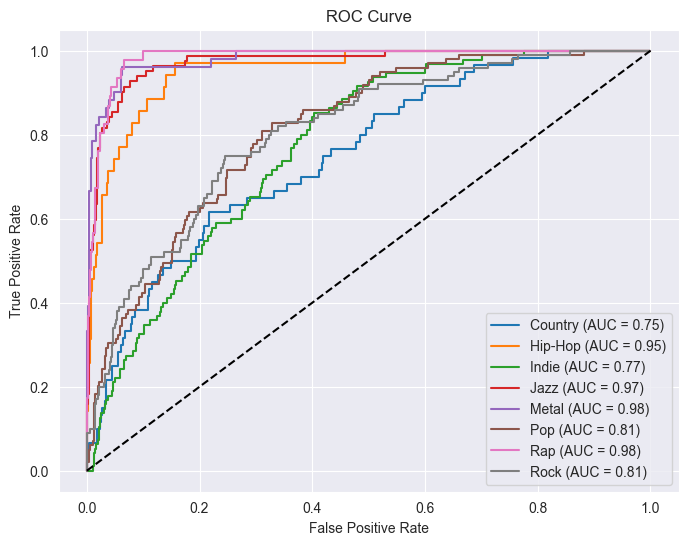

In [51]:
# AUC-ROC curve
from sklearn.metrics import roc_auc_score, roc_curve

# plot the ROC curve
plt.figure(figsize=(8, 6))
for i in range(8):
    roc_auc = roc_auc_score(y_lyrics[:, i], combined_probs[:, i])
    fpr, tpr, _ = roc_curve(y_lyrics[:, i], combined_probs[:, i])
    plt.plot(fpr, tpr, label=f"{label_encoder.classes_[i]} (AUC = {roc_auc:.2f})")
    
np.save("auc_roc/combined_probs_weighted.npy", combined_probs)
np.save("auc_roc/y_lyrics_weighted.npy", y_lyrics)
np.save("auc_roc/label_encoder_weighted.npy", label_encoder.classes_)
    
plt.plot([0, 1], [0, 1], color="black", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.style.use("fast")
plt.legend()
plt.show()

In [52]:
from matplotlib.colors import LinearSegmentedColormap

colors = ["white", "#455681"]  # White to #455681 gradient
custom_cmap = LinearSegmentedColormap.from_list("custom_white_to_blue", colors)

Weighted Voting Accuracy: 0.5176
Classification Report:
              precision    recall  f1-score   support

     Country       0.45      0.08      0.14        60
     Hip-Hop       0.78      0.51      0.62        35
       Indie       0.32      0.49      0.39        95
        Jazz       0.56      0.90      0.69        82
       Metal       0.58      0.88      0.70        51
         Pop       0.78      0.14      0.24        99
         Rap       0.62      0.91      0.74        46
        Rock       0.54      0.49      0.51       100

    accuracy                           0.52       568
   macro avg       0.58      0.55      0.50       568
weighted avg       0.56      0.52      0.47       568

Weighted Voting F1 Score: 0.4725


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

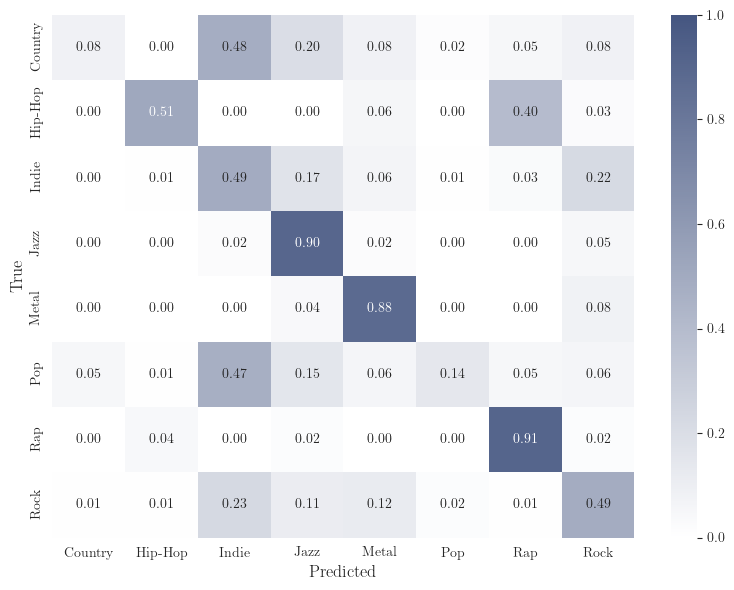

In [53]:
# True labels
true_labels = audio_labels
 # Assuming all labels are the same

# Accuracy
accuracy = accuracy_score(true_labels, final_preds)
print(f"Weighted Voting Accuracy: {accuracy:.4f}")

# Classification report
print("Classification Report:")
print(classification_report(true_labels, final_preds, target_names=label_encoder.classes_))

# F1 score
f1 = f1_score(true_labels, final_preds, average="weighted")
print(f"Weighted Voting F1 Score: {f1:.4f}")

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, final_preds)

# Normalize the confusion matrix
conf_matrix = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

# Use latex
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Plot normalized confusion matrix
plt.figure(figsize=(8, 6))

sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap=custom_cmap, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, vmax=1.0)
plt.xlabel("Predicted", fontdict={"fontsize": 12})
plt.ylabel("True", fontdict={"fontsize": 12})
plt.tight_layout()
plt.savefig("confusion_matrix_weighted_voting_2.eps", dpi=300)
plt.show()